# 2.4 Data Quality Report

Here, we'll provide an assessment of the quality of the data:

* Missing values: Identify any missing data and discuss potential methods for handling it.
* Consistency of data: Check the consistency of data across different data sources and over time.
* Outliers: Identify any outliers in the data and discuss potential methods for handling them.
* Duplicate data: Check and report on any duplicate data points.
* Other potential problems: This could include things like erroneous values, mislabeled classes, irrelevant features, etc.

## 2.4.1 File access and save paths
Here we will import the helper functions and setup up the save paths for the data and figures that are generated

In [9]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# create the file paths for reading in data and for outputting figures and tables
DATA_PATH = f"../data/saville_row_east_west/"
OUTPUT_TABLES_PATH = f"../output/tables/2.4/"
OUTPUT_FIGURES_PATH = f"../output/figures/2.4/"

os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(OUTPUT_TABLES_PATH, exist_ok=True)
os.makedirs(OUTPUT_FIGURES_PATH, exist_ok=True)

# get custom color palette and colormap
from eda_helper import get_custom_palette, get_custom_colormap
custom_palette = get_custom_palette()
custom_colormap = get_custom_colormap()

# read in the files for exploration
east_df = pd.read_pickle(os.path.join(DATA_PATH, 'east_df.pkl'))
west_df = pd.read_pickle(os.path.join(DATA_PATH, 'west_df.pkl'))

### 2.4.2 Missing values
This section gives an overview of the total number of records available per day over the study period.

In [11]:
def daily_counts(df):
    count_df = df.groupby(by='date').agg({'value':'count','year-quarter':'first'}).reset_index()
    return count_df

In [12]:
print(OUTPUT_FIGURES_PATH)

../output/figures/2.4/


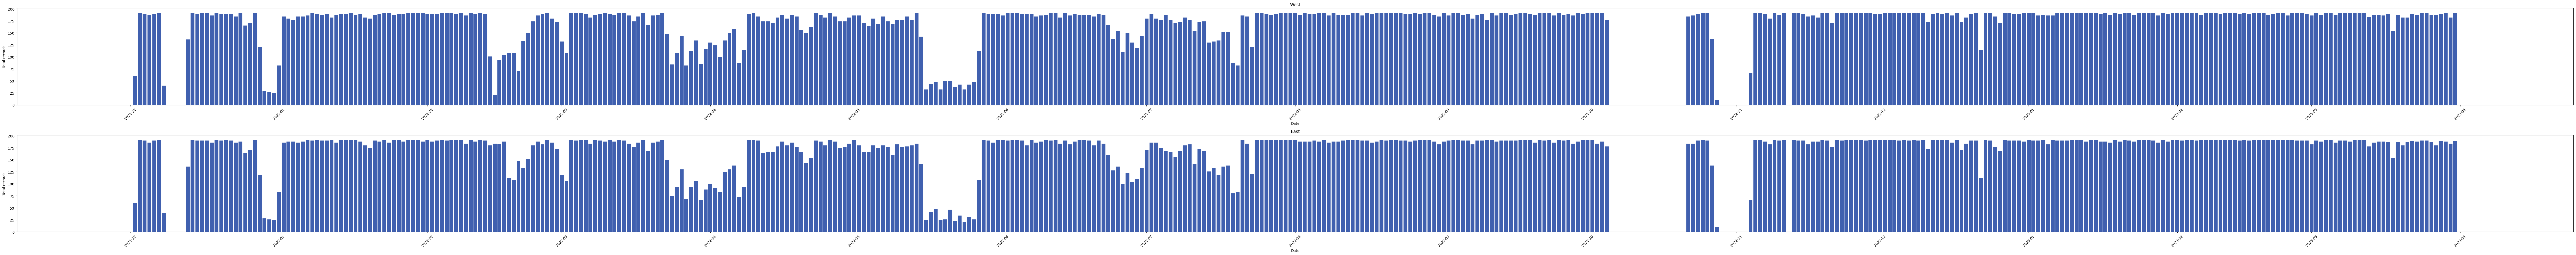

In [13]:
import matplotlib.dates as mdates

# formatted to be notebook/html friendly
fig, ax = plt.subplots(2, 1, figsize=(100,10))

# plot for the west sensor
ax[0].bar(x=daily_counts(west_df)['date'], height=daily_counts(west_df)['value'])
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Total records')
ax[0].set_title('West', fontsize=12)

# setting x-axis major locator
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
# formatting the x-ticks as dates
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# plot for the east sensor
ax[1].bar(x=daily_counts(east_df)['date'], height=daily_counts(east_df)['value'])
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Total records')
ax[1].set_title('East', fontsize=12)

# setting x-axis major locator
ax[1].xaxis.set_major_locator(mdates.MonthLocator())
# Formatting the x-ticks as dates
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# rotating the x-ticks for better visibility
for axes in ax:
    plt.setp(axes.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FIGURES_PATH, f'Total.svg'), bbox_inches='tight', dpi=360)

# formatted to be A4 document friendly
quarters = daily_counts(west_df)['year-quarter'].unique()
fig, axes = plt.subplots(len(quarters), 1, figsize=(16, 4*len(quarters)))

start_date = datetime.datetime(2021, 10, 1)  # define the starting date

for i, quarter in enumerate(quarters):
    df = daily_counts(east_df).sort_values('date')  # returns the daily counts from each df
    df = df[df['year-quarter'] == quarter]  # selects the counts in each month
    axes[i].bar(x=df['date'], height=df['value'])
    axes[i].set_title(f'{quarter}')

    if i == 0:  # If it's the first plot
        axes[i].set_xlim(start_date, df['date'].max())  # set the x-axis limits

plt.savefig(os.path.join(OUTPUT_FIGURES_PATH, f'Total records per day by quarter.svg'), bbox_inches='tight', dpi=200)
plt.close()

### 2.4.3 Consistency of the data
Here we can see an overview of each data point per day over the study period to further investigate any patterns in the lack of consistency.

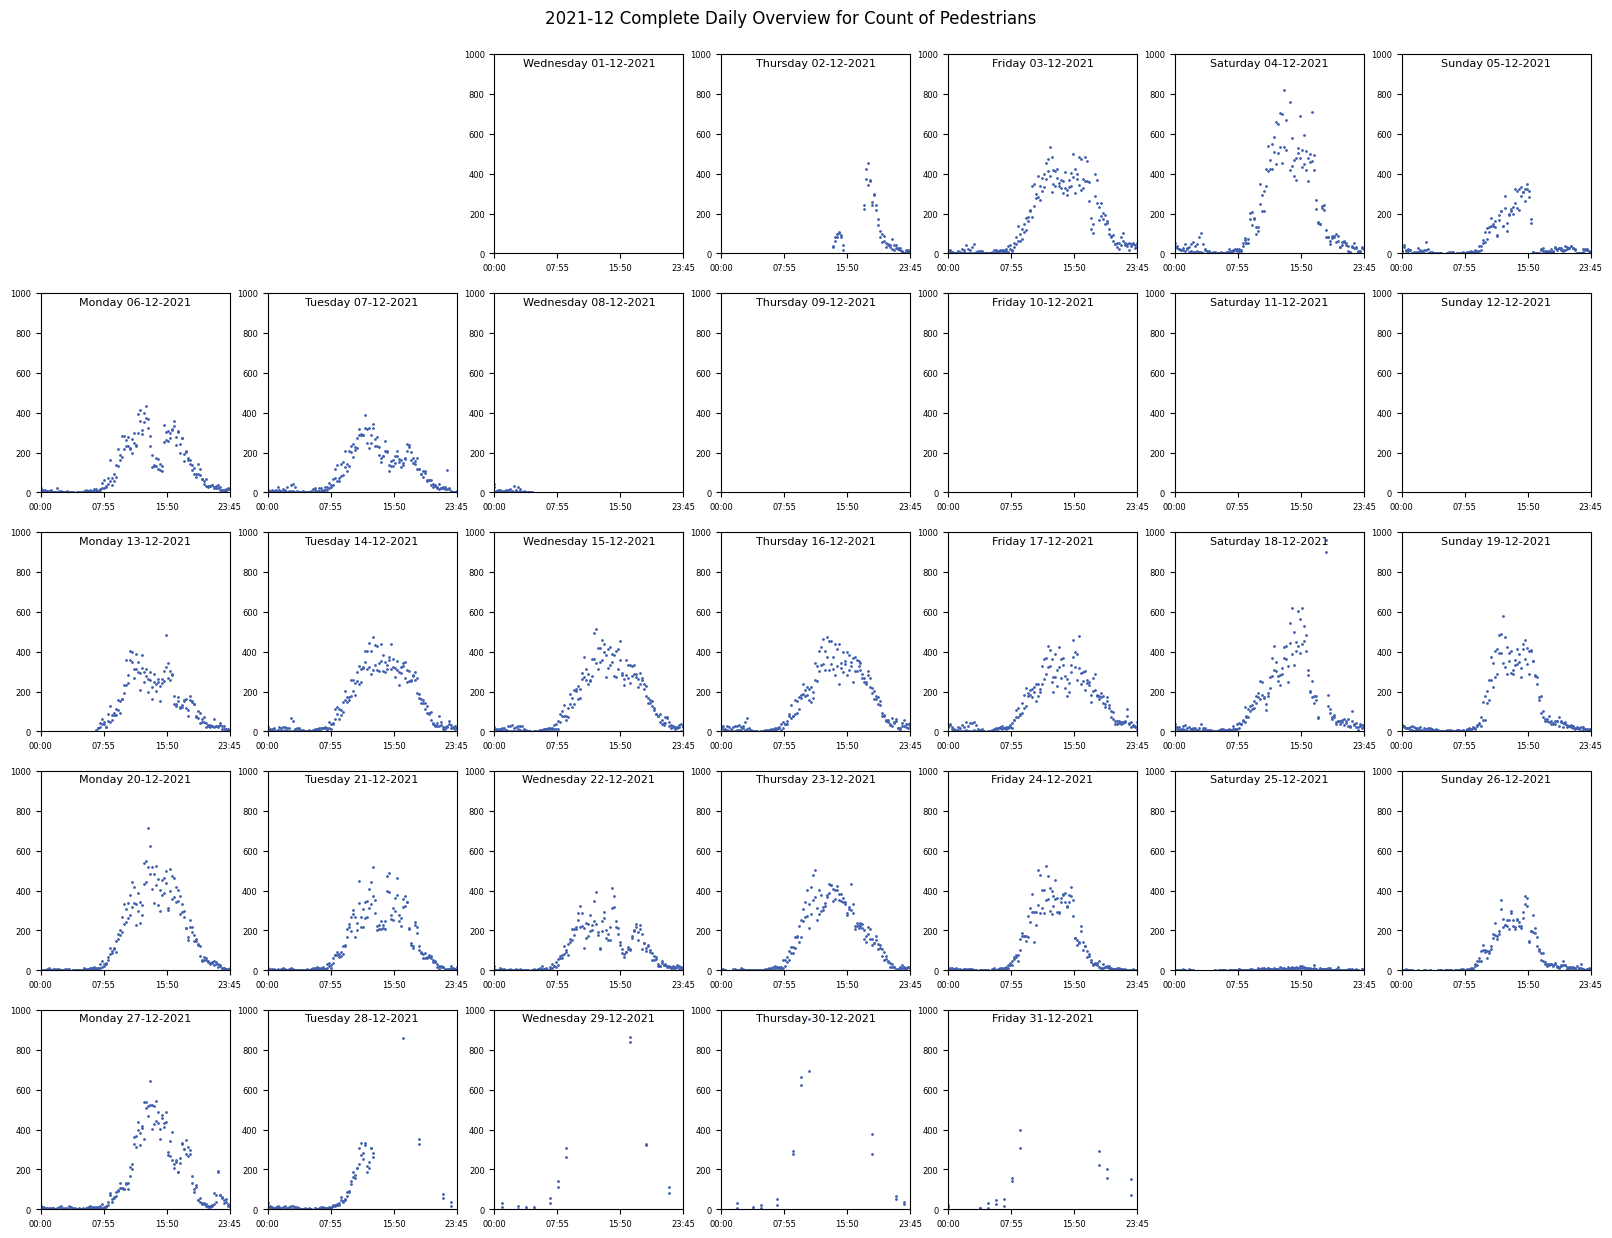

In [14]:
import math

# define a helper function outside of the loop to avoid redefining it each time
def time_to_minutes(time_obj):
    return time_obj.hour * 60 + time_obj.minute

# enumerate over the sorted and unique 'year-month' combinations from the DataFrame
for i, month in enumerate(sorted(east_df['year-month'].unique())):
    # copy a DataFrame containing only the data for the current month
    monthly_east_df = east_df[east_df['year-month'] == month].copy()

    # convert the 'time' column to minutes using the helper function
    monthly_east_df['time_minutes'] = monthly_east_df['time'].apply(time_to_minutes)

    # determine the start and end dates for the current month
    start_date = pd.to_datetime(month + '-01')
    end_date = start_date + pd.offsets.MonthEnd(1)
    num_days = (end_date - start_date).days + 1

    # prepare the x-axis ticks and labels
    x_ticks = np.linspace(0, 60 * 23 + 45, 4)
    x_tick_labels = [f'{int(tick // 60):02d}:{int(tick % 60):02d}' for tick in x_ticks]

    # initialize the date for the first subplot
    current_date = start_date

    # prepare subplots
    fig, axes = plt.subplots(math.ceil((num_days + start_date.weekday()) / 7), 7, figsize=(20, 3 * math.ceil((num_days + start_date.weekday()) / 7)))

    # flatten the axes to iterate easily, and then reassign it to the proper week/day
    axes = axes.flatten()

    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # turn off the axes for the days before the start of the month
    for j in range(start_date.weekday()):
        axes[j].axis('off')

    for j in range(start_date.weekday(), num_days + start_date.weekday()):

        # plot the data for the current day
        df = monthly_east_df[monthly_east_df['date'] == current_date]
        axes[j].scatter(x=df['time_minutes'], y=df['value'], s=1)
        axes[j].set_title(f'{days_of_week[current_date.weekday()]} {current_date.strftime("%d-%m-%Y")}', fontsize=8, y=0.9)
        axes[j].tick_params(axis='both', labelsize=6)
        axes[j].set_xticks(x_ticks)
        axes[j].set_xticklabels(x_tick_labels)
        axes[j].set_xlim(0, 60 * 23 + 45)
        axes[j].set_ylim(0, 1000)
        # axes[j].axis('off')

        # move to the next day
        current_date += pd.DateOffset(days=1)

    # turn off any remaining axes
    for j in range(num_days + start_date.weekday(), len(axes)):
        axes[j].axis('off')

    # set the title for the figure and save it to a file
    plt.suptitle(f'{month} Complete Daily Overview for Count of Pedestrians', y=0.91, fontsize=12)
    plt.savefig(os.path.join(OUTPUT_FIGURES_PATH, f'Complete Daily Overview {month}.svg'), bbox_inches='tight', dpi=200)

    if i == 0:
        plt.show()
    else:
        plt.close()

###  Remove missing values
We should remove some of the days where there is very little data. For this we will use a threshold of 98% data completeness.

In [ ]:
# Group by date and count number of entries for each date
date_counts = west_df.groupby('date').size()

# Calculate threshold for 90% completeness
threshold = 0.90 * 192

# Find the dates that have at least threshold number of entries
valid_dates = date_counts[date_counts >= threshold].index

# Select only the rows that have a date in valid_dates
df_selected = west_df[west_df['date'].isin(valid_dates)]

len(west_df), len(df_selected)

df_selected.to_pickle(os.path.join(DATA_PATH, 'west_complete_days_df.pkl'))

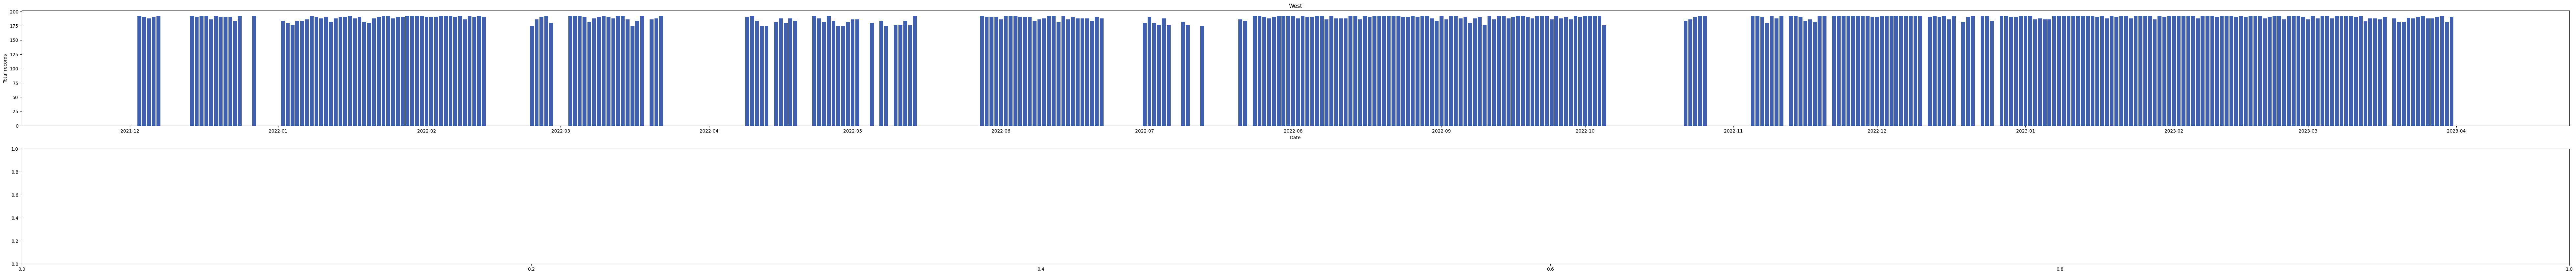

In [ ]:
import matplotlib.dates as mdates

# formatted to be notebook/html friendly
fig, ax = plt.subplots(2, 1, figsize=(100,10))

# plot for the west sensor
ax[0].bar(x=daily_counts(df_selected)['date'], height=daily_counts(df_selected)['value'])
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Total records')
ax[0].set_title('West', fontsize=12)

# setting x-axis major locator
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
# Formatting the x-ticks as dates
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))